Advanced Lane Finding Project
The goals / steps of this project are the following:

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
Apply a distortion correction to raw images.
Use color transforms, gradients, etc., to create a thresholded binary image.
Apply a perspective transform to rectify binary image ("birds-eye view").
Detect lane pixels and fit to find the lane boundary.
Determine the curvature of the lane and vehicle position with respect to center.
Warp the detected lane boundaries back onto the original image.
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

camera_cal/calibration15.jpg


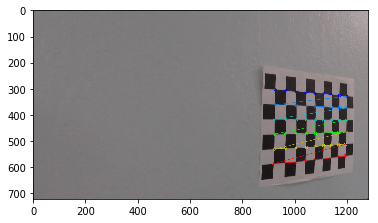

camera_cal/calibration14.jpg


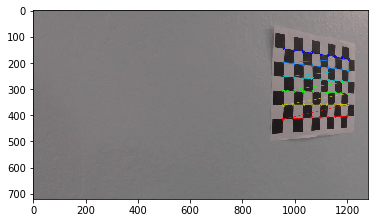

camera_cal/calibration11.jpg


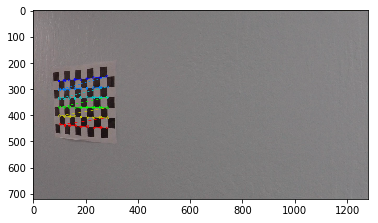

camera_cal/calibration6.jpg


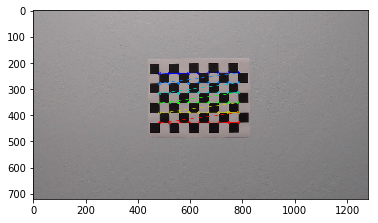

camera_cal/calibration2.jpg


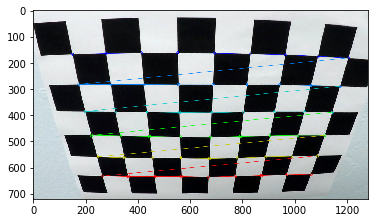

camera_cal/calibration13.jpg


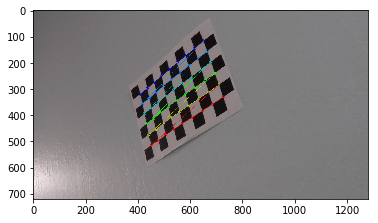

camera_cal/calibration12.jpg


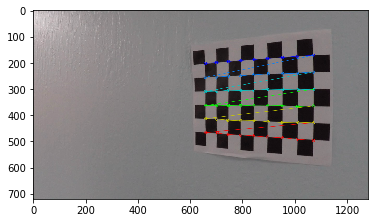

camera_cal/calibration5.jpg
camera_cal/calibration18.jpg


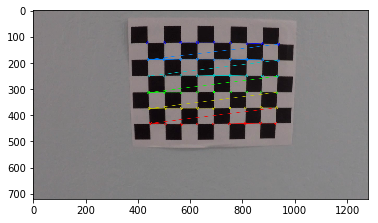

camera_cal/calibration7.jpg


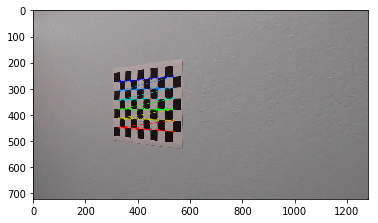

camera_cal/calibration17.jpg


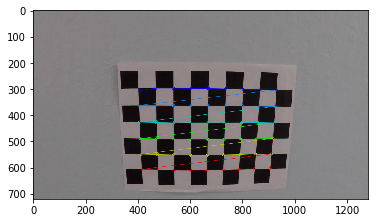

camera_cal/calibration9.jpg


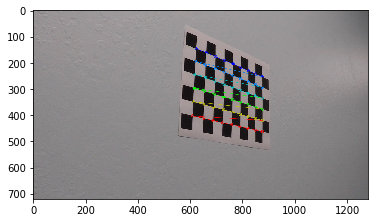

camera_cal/calibration1.jpg
camera_cal/calibration3.jpg


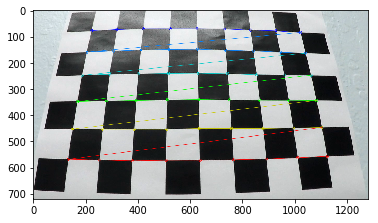

camera_cal/calibration20.jpg


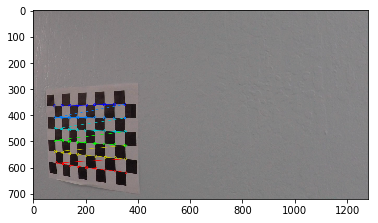

camera_cal/calibration4.jpg
camera_cal/calibration10.jpg


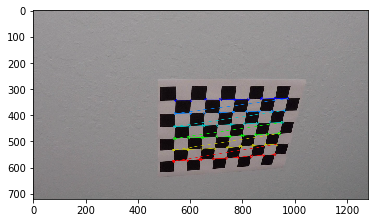

camera_cal/calibration16.jpg


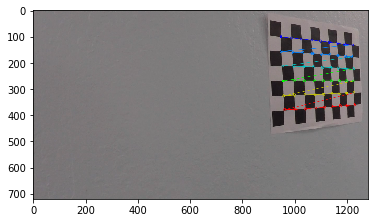

camera_cal/calibration8.jpg


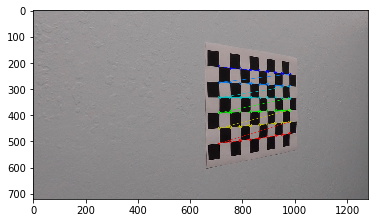

camera_cal/calibration19.jpg


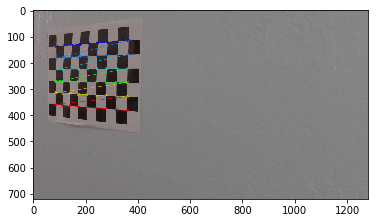

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import os

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
for fname in images:
    print (fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        #print (np.shape(objp))
        imgpoints.append(corners)
        #print (np.shape(corners))

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        plt.show()


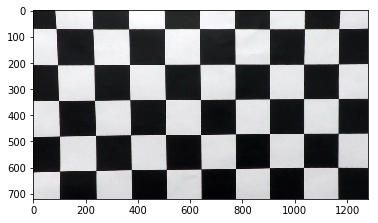

In [3]:
img = cv2.imread('camera_cal/calibration1.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
undist=cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)
plt.show()

In [ ]:
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    undist=cv2.undistort(img, mtx, dist, None, mtx)
    #plt.imshow(undist)
    #plt.show()

In [ ]:
images= glob.glob('test_images/*.jpg')
thresh=(170,255)
thresh_c=(150,200)
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

for fname in images:
    print (fname)
    #img = cv2.imread(fname)
    image = mpimg.imread(fname)
    imshape = image.shape
    image_height = image.shape[0]
    image_width = image.shape[1]
    img_size = (image.shape[1], image.shape[0])
    src = np.float32([[189, image_height], [572,464],[711,464], [1102,image_height]])
    dst = np.float32([[320,image_height], [320,0], [950,0], [950,image_height]])
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    g_undist=cv2.undistort(gray, mtx, dist, None, mtx)
    
    undist=cv2.undistort(image, mtx, dist, None, mtx)
    R=undist[:,:,0]
    binary_r = np.zeros_like(R)
    binary_r[(R > thresh[0]) & (R <= thresh[1])] = 1
    hls=cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    s_channel= hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    sobelx=cv2.Sobel(g_undist, cv2.CV_64F, 1,0)
    abs_sobelx=np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    thresh_min = 40
    thresh_max = 150
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(binary_output == 1) | (sxbinary == 1)] = 1
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(combined_binary, M, img_size)
    
    histogram=np.sum(warped[warped.shape[0]//2:, :], axis=0)
    out_img = np.dstack((warped, warped, warped))
    mid_point=np.int(histogram.shape[0]//2)
    left_base=np.argmax(histogram[:mid_point])
    right_base=np.argmax(histogram[mid_point:])+mid_point
    
    nwindows=9
    margin=40
    minpix=50
    
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    window_height=np.int(warped.shape[0]//nwindows)
    leftx_current=left_base
    rightx_current=right_base
    
    left_lane_inds=[]
    right_lane_inds=[]
    
    for window in range(nwindows):
        win_y_low=warped.shape[0]-(window+1)*window_height
        win_y_high=warped.shape[0]-window*window_height
        
        win_xleft_low=leftx_current-margin
        win_xleft_high = leftx_current + 1.8*margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass 
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    y_eval = np.max(ploty)
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    
    left_temp_x = left_fitx[::-1]  # Reverse to match top-to-bottom in y
    right_temp_x = right_fitx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty*ym_per_pix, left_temp_x*xm_per_pix, 2)
    right_fit = np.polyfit(ploty*ym_per_pix, right_temp_x*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print (left_curverad, right_curverad)
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

        
    #plt.figure()
    #plt.plot(histogram)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #plt.figure()
    plt.imshow(out_img)
    #plt.imshow(warped,cmap='gray')
    #plt.figure()
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.imshow(out_img)
    plt.show()

In [ ]:
print (histogram.shape)
mid_point=np.int(histogram.shape[0]//2)
left_base=np.argmax(histogram[:mid_point])
right_base=np.argmax(histogram[mid_point:])+mid_point
print (left_base, right_base)

In [ ]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 255, 255], thickness=1):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

In [ ]:
images= glob.glob('test_images/*.jpg')
thresh=(170,255)
thresh_c=(150,200)
for fname in images:
    print (fname)
    #img = cv2.imread(fname)
    image = mpimg.imread(fname)
    imshape = image.shape
    image_height = image.shape[0]
    image_width = image.shape[1]
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    g_undist=cv2.undistort(gray, mtx, dist, None, mtx)
    
    undist=cv2.undistort(image, mtx, dist, None, mtx)
    R=undist[:,:,0]
    binary_r = np.zeros_like(R)
    binary_r[(R > thresh[0]) & (R <= thresh[1])] = 1
    hls=cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    s_channel= hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    sobelx=cv2.Sobel(g_undist, cv2.CV_64F, 1,0)
    abs_sobelx=np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    thresh_min = 40
    thresh_max = 150
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(binary_output == 1) | (sxbinary == 1)] = 1
    
    v1 = (0, image_height)
    v2 = (int(image_width/2 - image_width*.01), image_height/2 + int(image_height*.08))
    v3 = (int(image_width/2 + image_width*.01), image_height/2 + int(image_height*.08))
    v4 = (image_width, image_height)
    vertices = np.array([[v1, v2, v3, v4]], dtype=np.int32)
    #vertices = np.array([[(100,imshape[0]),(450, 320), (520, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    mask_edge=region_of_interest(combined_binary, vertices)
    rho=2
    theta=np.pi/180
    threshold=100
    min_line_len=100
    max_line_gap=250
    line_img=hough_lines(mask_edge, rho, theta, threshold, min_line_len, max_line_gap)
    
    #line_edge=weighted_img(line_img, image, α=0.8, β=1., γ=0.)

    plt.imshow(line_img)
    plt.show()

In [ ]:
images= glob.glob('test_images/*.jpg')
thresh=(170,255)
thresh_c=(150,200)
for fname in images:
    print (fname)
    #img = cv2.imread(fname)
    image = mpimg.imread(fname)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    g_undist=cv2.undistort(gray, mtx, dist, None, mtx)
    
    undist=cv2.undistort(image, mtx, dist, None, mtx)
    R=undist[:,:,0]
    binary_r = np.zeros_like(R)
    binary_r[(R > thresh[0]) & (R <= thresh[1])] = 1
    hls=cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    s_channel= hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    sobelx=cv2.Sobel(g_undist, cv2.CV_64F, 1,0)
    abs_sobelx=np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    thresh_min = 40
    thresh_max = 150
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(binary_output == 1) | (sxbinary == 1)] = 1
    
    v1 = (0, image_height)
    v2 = (int(image_width/2 - image_width*.01), image_height/2 + int(image_height*.08))
    v3 = (int(image_width/2 + image_width*.01), image_height/2 + int(image_height*.08))
    v4 = (image_width, image_height)
    vertices = np.array([[v1, v2, v3, v4]], dtype=np.int32)
    #vertices = np.array([[(100,imshape[0]),(450, 320), (520, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    mask_edge=region_of_interest(com, vertices)
    plt.imshow(image)
    plt.imshow(combined_binary, cmap='gray')
    plt.show()

In [ ]:
images= glob.glob('test_images/*.jpg')
thresh=(90,255)
for fname in images:
    print (fname)
    #img = cv2.imread(fname)
    image = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    undist=cv2.undistort(img, mtx, dist, None, mtx)
    hls=cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    s_channel= hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    
    
    plt.imshow(binary_output, cmap='gray')
    plt.show()